In [1]:
# initialization
import random
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram

In [10]:
#generate 4 random secret binary string of size from 1~4
sList=[]
for i in range(1, 5): #loop i from 1~4
    key=str(bin(random.getrandbits(i))[2:]) #generate a key with i bits, [2:0] is used to format the return string from getrandbits(i)
    j=len(key) #get the length of the key
    while j<i:#add padding in front of the key if the length is not equal to i
        key='0'+key
        j+=1
    sList.append(key) # append the key to the list
print(sList)

['0', '11', '001', '0110']


In [3]:
#initialize n qubits, with an addition auxiliary qubit
#we also need n bits to store the results
def buildQTcirc(inputString):
    n=len(inputString)
    circuit=QuantumCircuit(n+1, n)

    #put auxiliary qubit in state |->
    circuit.h(n)
    circuit.z(n)

    #apply Hadmard gates before querying the oracle
    #put rest of the qubits in state |+>
    for i in range(n):
        circuit.h(i)

    #apply a barrier
    circuit.barrier()    

    #oracle
    temp=inputString[::-1]#reverse input string for qiskit's qubit ordering
    for q in range(n):
        if temp[q]=='1':
            circuit.cx(q, n) #apply CNOT

    #apply a barrier
    circuit.barrier()

    #apply Hadmard gates after querying the oracle
    for i in range(n):
        circuit.h(i)

    #measure the qubits onto classical bits    
    for i in range(n):
        circuit.measure(i, i)
        
    return circuit

In [11]:
#use local simulator to simulate quantum circuit with various size
timeList_sim=[]
answerList_sim=[]
for s in sList:
    print(s)
    circuit=buildQTcirc(s) #construct circuit
    aer_sim=Aer.get_backend('aer_simulator') #set backend as simulator
    circ_sim=transpile(circuit, aer_sim)#transpile the circuit
    results_sim=aer_sim.run(circ_sim).result()#get the results of the circuit execution
    answer_sim=results_sim.get_counts()#get the counts of the results
    time_sim=results_sim.time_taken #get the time taken of the circuit execution
    timeList_sim.append(time_sim) #append the time taken to the List
    answerList_sim.append(answer_sim)
print(answerList_sim)
print(timeList_sim)

0
11
001
0110
[{'0': 1024}, {'11': 1024}, {'001': 1024}, {'0110': 1024}]
[0.03690052032470703, 0.0026428699493408203, 0.0029518604278564453, 0.0030183792114257812]


In [6]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
from qiskit.tools.monitor import backend_overview
backend_overview()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

ibmq_manila                  ibmq_quito                   ibmq_belem
-----------                  ----------                   ----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 48             Pending Jobs: 29             Pending Jobs: 21
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      154.8          Avg. T1:      103.5          Avg. T1:      88.4
Avg. T2:      57.8           Avg. T2:      127.5          Avg. T2:      94.0



ibmq_lima                    ibmq_bogota                  ibmq_armonk
---------                    -----------                  -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  1
Pending Jobs: 20             Pending Jobs: 58             Pending Jobs: 1
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operati

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

timeList_real=[]
answerList_real=[]
shots = 1024
for s in sList:
    circuit=buildQTcirc(s) #construct circuit
    circ_real = transpile(circuit, backend) #tranpile the circuit
    job = backend.run(circ_real, shots=shots)#create a job for execution

    job_monitor(job, interval=2)#monitorize the job
    # Get the results from the computation
    results_real = job.result()#get the results of the circuit execution
    answer_real = results_real.get_counts() #get the counts from the results
    answerList_real.append(answer_real)#append the answer to the list
    time_real=results_real.time_taken #get the time taken of the circuit execution
    timeList_real.append(time_real) #append the time to the list
    
print(answerList_real)    
print(timeList_real)

Job Status: job is queued (10)    

In [11]:
#classical approach
#qeury the oracle with a binary string with only one '1' in all possible positions

#define a oracle where f(x)=s*x mod 2
def oracle(s, input, n):
    sum=0
    #bit product function of s and input
    for i in range(n):
        sum+=int(s[i])*int(input[i])
    ret=sum%2
    return ret

In [12]:
#qeury the oracle
def qeuryOracle(s, n):
    result=''
    for i in range(n):
            input=''
            for j in range(n):
                if j<i:
                    input+='0'
                elif j==i:
                    input+='1'
                elif j>i:
                    input+='0'
            if oracle(s, input, n)==1:
                result+='1'
            else:
                result+='0'
    return result

In [14]:
answerList_classical=[]
timeList_classical=[]
for s in sList:
    n=len(s)
    %timeit qeuryOracle(s, n)
    answer=qeuryOracle(s, n)
    answerList_classical.append(answer)
print(answerList_classical)

1.73 µs ± 28.3 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
4.41 µs ± 149 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
8.12 µs ± 208 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
13 µs ± 243 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
['0', '00', '011', '0110']


[1.73e-06, 4.41e-06, 8.12e-06, 1.3e-05]
[0.0030066967, 0.0029921532, 0.0029883385, 0.0020451546]
[3.154468774, 3.617537021, 4.122985839, 4.183508157]


Text(0.5, 1.0, 'Bernstein-Vazirani algorithm runtime')

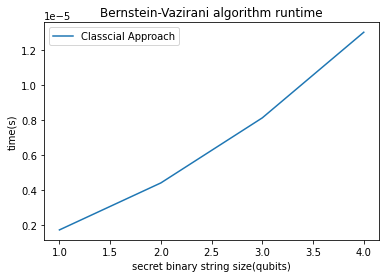

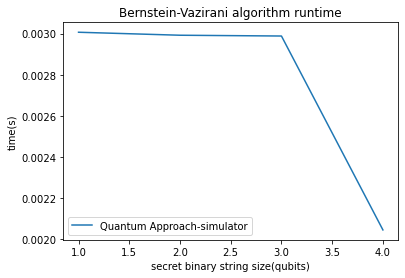

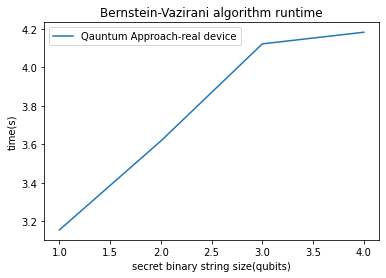

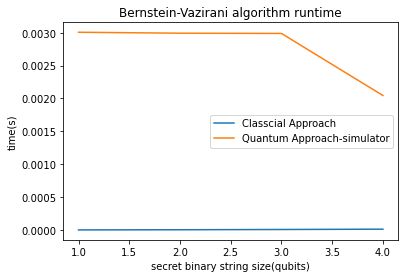

In [16]:
#runtime obtained from above cells
timeList_classical=[1.73e-6, 4.41e-6, 8.12e-6, 13e-6]
timeList_sim=[0.0030066967, 0.0029921532, 0.0029883385, 0.0020451546]
timeList_real=[3.154468774, 3.617537021, 4.122985839, 4.183508157]
n=[1, 2, 3, 4]
print(timeList_classical)
print(timeList_sim)
print(timeList_real)

fig, ax1=plt.subplots()
ax1.plot(n,timeList_classical, label="Classcial Approach")
ax1.set_xlabel("secret binary string size(qubits)")
ax1.set_ylabel("time(s)")
ax1.legend()
plt.title("Bernstein-Vazirani algorithm runtime")

fig, ax2=plt.subplots()
ax2.plot(n,timeList_sim, label="Quantum Approach-simulator")
ax2.set_xlabel("secret binary string size(qubits)")
ax2.set_ylabel("time(s)")
ax2.legend()
plt.title("Bernstein-Vazirani algorithm runtime")

fig, ax3=plt.subplots()
ax3.plot(n,timeList_real, label="Qauntum Approach-real device")
ax3.set_xlabel("secret binary string size(qubits)")
ax3.set_ylabel("time(s)")
ax3.legend()
plt.title("Bernstein-Vazirani algorithm runtime")

fig, ax4=plt.subplots()
ax4.plot(n,timeList_classical, label="Classcial Approach")
ax4.plot(n,timeList_sim, label="Quantum Approach-simulator")
#ax4.plot(n,timeList_real, label="Qauntum Approach-real device")
ax4.set_xlabel("secret binary string size(qubits)")
ax4.set_ylabel("time(s)")
ax4.legend()
plt.title("Bernstein-Vazirani algorithm runtime")